<a href="https://colab.research.google.com/github/AbdulBari8455/BERT_Fine_Tunning_on_IMDB_Ass02/blob/main/LLM_Assignment_02_Abdul_Bari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Device Setup

In [1]:
!pip install torch torchvision transformers datasets matplotlib pandas scikit-learn wordcloud
!pip install --upgrade --force-reinstall fsspec datasets
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.optim import AdamW
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import precision_recall_fscore_support
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
  Using cached datasets-4.0.0-py3-none-any.whl.metadata (19 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached numpy-2.3.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached pyarrow-20.0.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached xxhash-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached huggingface_hub-0.33.2-py3-none-any.whl.metadata (14 kB)
  Using cached packaging-25.0-py

In [2]:
# Set device (Check for GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device in use:", device)

Device in use: cuda


# Load IMDb Dataset

In [3]:
imdb_raw = load_dataset("imdb")
df_train_full = pd.DataFrame(imdb_raw['train'])
df_test_full = pd.DataFrame(imdb_raw['test'])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

# Subsample the Data (Balancing Subset Data)

In [4]:
# Use 1500 positive, 1500 negative samples for training, similar for test
def sample_balanced(df, n_per_class=1500):
    pos_samples = df[df['label'] == 1].sample(n=n_per_class, random_state=42)
    neg_samples = df[df['label'] == 0].sample(n=n_per_class, random_state=42)
    return pd.concat([pos_samples, neg_samples]).sample(frac=1, random_state=42).reset_index(drop=True)

df_train = sample_balanced(df_train_full, n_per_class=2000)
df_test = sample_balanced(df_test_full, n_per_class=500)


# Data Visualization: Label Distribution & Review Lengths

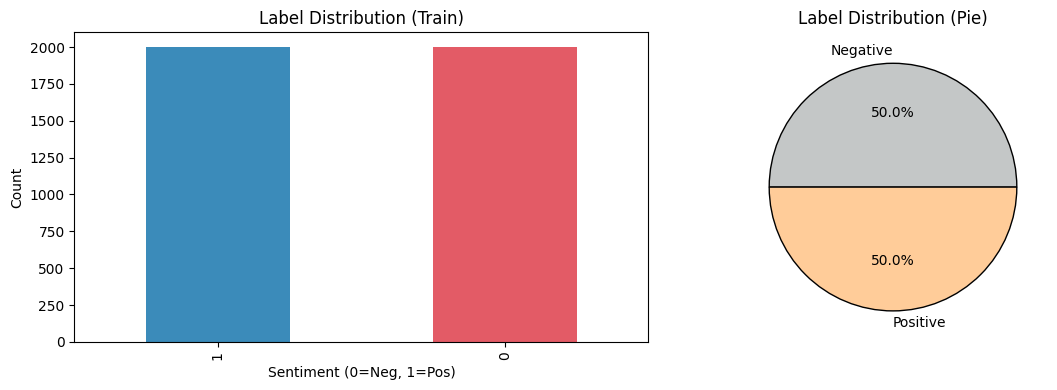

In [21]:
# --- Label Distribution: Bar & Pie
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
df_train['label'].value_counts().plot(kind='bar', color=['#3b8bba', '#e35b66'], ax=axs[0])
axs[0].set_title('Label Distribution (Train)')
axs[0].set_xlabel('Sentiment (0=Neg, 1=Pos)')
axs[0].set_ylabel('Count')

df_train['label'].value_counts().plot.pie(labels=['Negative', 'Positive'],
                                          autopct='%1.1f%%',
                                          colors=['#c4c7c7', '#ffcc99'],
                                          ax=axs[1], wedgeprops=dict(edgecolor='k'))
axs[1].set_ylabel('')
axs[1].set_title('Label Distribution (Pie)')

plt.tight_layout()
plt.show()


In [6]:
df_train['label'].value_counts().plot.pie(labels=['Negative', 'Positive'],
                                          autopct='%1.1f%%',
                                          colors=['#c4c7c7', '#ffcc99'],
                                          ax=axs[1], wedgeprops=dict(edgecolor='k'))
axs[1].set_ylabel('')
axs[1].set_title('Label Distribution (Pie)')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

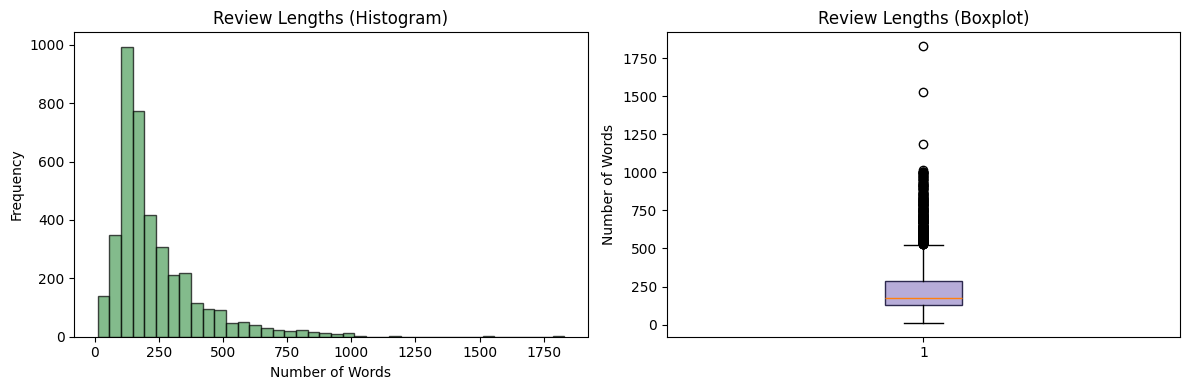

In [7]:
# --- Review Length Histogram & Boxplot
df_train['review_length'] = df_train['text'].apply(lambda x: len(x.split()))

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(df_train['review_length'], bins=40, color='#4e9e5c', alpha=0.7, edgecolor='black')
axs[0].set_title('Review Lengths (Histogram)')
axs[0].set_xlabel('Number of Words')
axs[0].set_ylabel('Frequency')

axs[1].boxplot(df_train['review_length'], patch_artist=True, boxprops=dict(facecolor='#b7acd8', color='#2d294e'))
axs[1].set_title('Review Lengths (Boxplot)')
axs[1].set_ylabel('Number of Words')

plt.tight_layout()
plt.show()

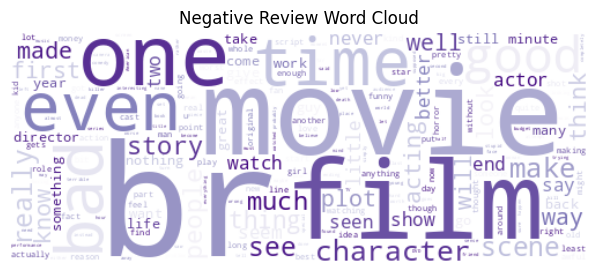

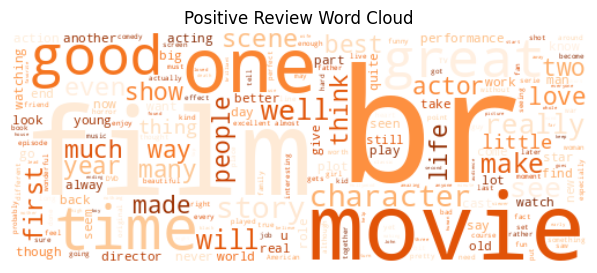

In [8]:
# Word Clouds for Positive/Negative Reviews
positive_text = " ".join(df_train[df_train['label'] == 1]['text'])
negative_text = " ".join(df_train[df_train['label'] == 0]['text'])

wordcloud_params = dict(width=500, height=200, background_color='white', collocations=False)

plt.figure(figsize=(8,3))
wc_neg = WordCloud(**wordcloud_params, colormap='Purples').generate(negative_text)
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Review Word Cloud')
plt.show()

plt.figure(figsize=(8,3))
wc_pos = WordCloud(**wordcloud_params, colormap='Oranges').generate(positive_text)
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Review Word Cloud')
plt.show()


# Prepare Lists for Model Input



In [9]:
train_texts = df_train['text'].tolist()
train_labels = df_train['label'].tolist()
test_texts = df_test['text'].tolist()
test_labels = df_test['label'].tolist()

# Define Custom PyTorch Dataset

In [10]:
class IMDBReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        encoded = self.tokenizer(self.texts[idx],
                                 truncation=True,
                                 padding='max_length',
                                 max_length=self.max_len,
                                 return_tensors='pt')
        data_out = {k: v.squeeze(0) for k, v in encoded.items()}
        data_out['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return data_out

# Tokenizer & DataLoader Setup

In [11]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
seq_max_len = 256

train_dataset = IMDBReviewDataset(train_texts, train_labels, bert_tokenizer, seq_max_len)
test_dataset = IMDBReviewDataset(test_texts, test_labels, bert_tokenizer, seq_max_len)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Model Initialization

In [12]:
model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model_bert = model_bert.to(device)

optimizer = AdamW(model_bert.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Print Sample Comments and Labels

In [13]:
print("\n=== Sample Test Reviews (Before Training) ===\n")
for i in range(3):
    print(f"Review: {test_texts[i][:120]}...")
    print(f"Label (True): {test_labels[i]}\n")


=== Sample Test Reviews (Before Training) ===

Review: I must say I was really excited about this film before renting it as it was an Adam Sandler "Happy Madison" production a...
Label (True): 0

Review: ...not to waste your time watching this vanity project. I've had my comment deleted twice now, for reasons that I have y...
Label (True): 0

Review: I'm not sure this film could ever match the first one, even if it starred the original seven (notwithstanding the fact t...
Label (True): 0



# Model Training Loop

In [14]:
num_epochs = 8  # Number of epochs
train_loss_values = []

for ep in range(num_epochs):
    model_bert.train()
    cumulative_loss = 0.0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        att_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model_bert(input_ids=input_ids, attention_mask=att_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        cumulative_loss += loss.item()
    avg_loss = cumulative_loss / len(train_loader)
    train_loss_values.append(avg_loss)
    print(f"Epoch {ep+1}/{num_epochs} | Train Loss: {avg_loss:.4f}")

Epoch 1/8 | Train Loss: 0.3546
Epoch 2/8 | Train Loss: 0.1765
Epoch 3/8 | Train Loss: 0.0843
Epoch 4/8 | Train Loss: 0.0469
Epoch 5/8 | Train Loss: 0.0354
Epoch 6/8 | Train Loss: 0.0233
Epoch 7/8 | Train Loss: 0.0245
Epoch 8/8 | Train Loss: 0.0166


# Plot Training Loss Curve

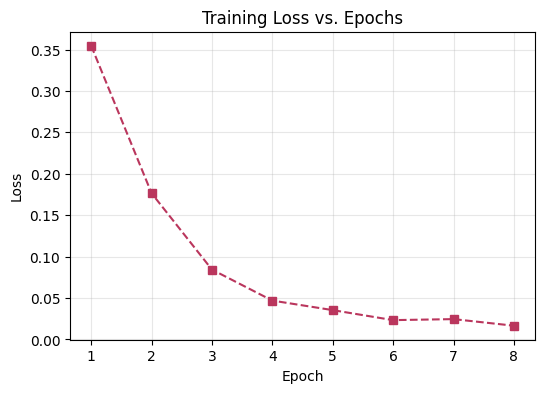

In [15]:
plt.figure(figsize=(6,4))
plt.plot(range(1, num_epochs+1), train_loss_values, marker='s', linestyle='--', color='#ba365d')
plt.title('Training Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)
plt.show()


# Moving Average of Loss

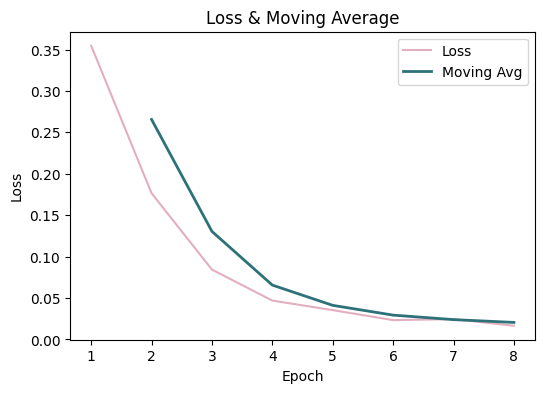

In [16]:
window = 2
if num_epochs > window:
    moving_avg = pd.Series(train_loss_values).rolling(window=window).mean()
    plt.figure(figsize=(6,4))
    plt.plot(range(1, num_epochs+1), train_loss_values, label='Loss', color='#ba365d', alpha=0.4)
    plt.plot(range(1, num_epochs+1), moving_avg, label='Moving Avg', color='#2d7179', linewidth=2)
    plt.title('Loss & Moving Average')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Model Evaluation: Prediction

In [17]:
model_bert.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        att_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model_bert(input_ids=input_ids, attention_mask=att_mask)
        pred_labels = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(pred_labels.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics and Confusion Matrix


Test Accuracy: 0.8900
Test F1 Score: 0.8878



<Figure size 500x400 with 0 Axes>

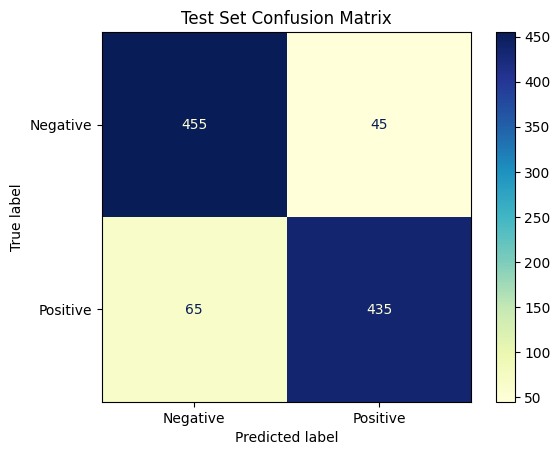

In [18]:
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
print(f"\nTest Accuracy: {acc:.4f}")
print(f"Test F1 Score: {f1:.4f}\n")

cm = confusion_matrix(all_labels, all_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])

plt.figure(figsize=(5,4))
cm_display.plot(cmap='YlGnBu')
plt.title('Test Set Confusion Matrix')
plt.show()

# F1 Score per Class (Bar Plot)

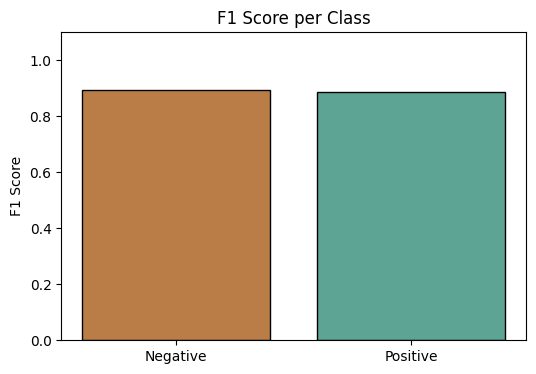

In [19]:
_, _, f1s, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
plt.figure(figsize=(6,4))
plt.bar(['Negative', 'Positive'], f1s, color=['#bb7d47', '#5da495'], edgecolor='k')
plt.title('F1 Score per Class')
plt.ylabel('F1 Score')
plt.ylim(0, 1.1)
plt.show()

# Show Comments and Predictions

In [20]:
print("\n=== Sample Predictions (After Training) ===\n")
for i in range(5):
    print(f"Review: {test_texts[i][:120]}...")
    print(f"Label (True): {test_labels[i]}")
    print(f"Label (Predicted): {all_preds[i]}\n")


=== Sample Predictions (After Training) ===

Review: I must say I was really excited about this film before renting it as it was an Adam Sandler "Happy Madison" production a...
Label (True): 0
Label (Predicted): 0

Review: ...not to waste your time watching this vanity project. I've had my comment deleted twice now, for reasons that I have y...
Label (True): 0
Label (Predicted): 0

Review: I'm not sure this film could ever match the first one, even if it starred the original seven (notwithstanding the fact t...
Label (True): 0
Label (Predicted): 0

Review: Porn legend Gregory Dark directs this cheesy horror flick that has Glen Jacobs (Kane from WWF/WWE/ whatever it calls its...
Label (True): 0
Label (Predicted): 0

Review: The Internet is a wondrous thing is it not? I am watching a taped episode of one of my all time favorite documentaries, ...
Label (True): 1
Label (Predicted): 0

